In [1]:
import numpy as np

In [2]:
size = 200
iterations = 100

In [3]:
def mandelbrot_python(m, size, iterations):
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0/size * i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

1 loops, best of 3: 5.26 s per loop


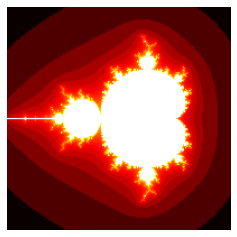

In [5]:
%%timeit
m = np.zeros((size, size))
mandelbrot_python(m, size, iterations)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.imshow(np.log(m), cmap=plt.cm.hot)
plt.xticks([])
plt.yticks([])

In [7]:
!conda install numba -y -q

Fetching package metadata: ....
Solving package specifications: ................
Package plan for installation in environment /Users/your/anaconda/envs/101:

The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    numba-0.23.1               |      np110py35_0         1.5 MB

The following NEW packages will be INSTALLED:

    llvmlite: 0.8.0-py35_0      
    numba:    0.23.1-np110py35_0



In [9]:
import numba
from numba import jit, complex128

@jit(locals=dict(c=complex128, z=complex128))
def mandelbrot_python(m, size, iterations):
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0/size * i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [11]:
%%timeit
m = np.zeros((size, size))
mandelbrot_python(m, size, iterations)


100 loops, best of 3: 7.88 ms per loop


#### numexpr

In [12]:
!conda install numexpr -q -y

Fetching package metadata: ....
Solving package specifications: ..............
# All requested packages already installed.
# packages in environment at /Users/your/anaconda/envs/101:
#
numexpr                   2.4.6               np110py35_0  


In [13]:
import numpy as np
import numexpr as ne

In [14]:
x, y, z = np.random.rand(3, 1000000)

In [15]:
%timeit x + (y**2 + (z*x + 1)*3)

10 loops, best of 3: 46.1 ms per loop


In [16]:
%timeit ne.evaluate('x + (y**2 + (z*x + 1)*3)')

100 loops, best of 3: 11.2 ms per loop


In [18]:
ne.ncores

2

In [19]:
for i in range(1, 3):
    ne.set_num_threads(i)
    %timeit ne.evaluate('x + (y**2 + (z*x + 1)*3)')

100 loops, best of 3: 15.2 ms per loop
100 loops, best of 3: 13.1 ms per loop


#### Cython

In [20]:
!conda install cython -q -y

Fetching package metadata: ....
Solving package specifications: ............
Package plan for installation in environment /Users/your/anaconda/envs/101:

The following NEW packages will be INSTALLED:

    cython: 0.23.4-py35_1



In [23]:
%load_ext cython

In [24]:
%%cython
import numpy as np
def mandelbrot_python(m, size, iterations):
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0/size * i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [26]:
%%timeit -n1 -r1 
# not much improve, need to declare variable type
size = 200
iterations = 100
m = np.zeros((size, size), dtype=np.int32)
mandelbrot_python(m, size, iterations)

1 loops, best of 1: 5.15 s per loop


In [31]:
%%cython -a
import numpy as np

# argument type desclarations
def mandelbrot_python(int[:, ::1] m, int size, int iterations):
    
    # cython declarations
    cdef int i, j, n
    cdef complex z, c
    
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0/size * i)
            z = 0
            for n in range(iterations):
                
                # replace np.abs() call, fast for array, slow for scalars
                if z.imag ** 2 + z.real ** 2 <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [32]:
%%timeit -n1 -r1
size = 200
iterations = 100
m = np.zeros((size, size), dtype=np.int32)
mandelbrot_python(m, size, iterations)

1 loops, best of 1: 35.7 ms per loop


#### standalone cython script

In [33]:
%%writefile mandelbrot.pyx
import numpy as np

# argument type desclarations
def mandelbrot_python(int[:, ::1] m, int size, int iterations):
    
    # cython declarations
    cdef int i, j, n
    cdef complex z, c
    
    for i in range(size):
        for j in range(size):
            c = -2 + 3.0 / size * j + 1j * (1.5 - 3.0/size * i)
            z = 0
            for n in range(iterations):
                
                # replace np.abs() call, fast for array, slow for scalars
                if z.imag ** 2 + z.real ** 2 <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

Writing mandelbrot.pyx


In [49]:
%%writefile setup.py
from distutils.core import setup
from distutils.extension import Extension
from Cython.Build import cythonize

setup(
    name='mandelbrot',
    ext_modules = cythonize('mandelbrot.pyx')
)

Overwriting setup.py


In [50]:
!python setup.py build_ext --inplace

running build_ext


In [51]:
!ls -al | grep mandelbrot

-rw-r--r--   1 your  staff     660155  1 28 18:25 mandelbrot.c
-rwxr-xr-x   1 your  staff     132500  1 28 18:25 mandelbrot.cpython-35m-darwin.so
-rw-r--r--   1 your  staff        625  1 28 18:09 mandelbrot.pyx


In [52]:
%%timeit -n1 -r1
from mandelbrot import mandelbrot
size = 200
iterations = 100
m = np.zeros((size, size), dtype=np.int32)
mandelbrot_python(m, size, iterations)

ImportError: cannot import name 'mandelbrot'

AttributeError: Client